# SVMとSVRのPythonによるフルスクラッチ実装

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## テスト用のデータを生成する

In [4]:
np.random.seed(seed=0)
data0 = 50             #1.データの数
data1 = 50
data2 = 50

mean0 = [3, 4]          #2.データ０における平均値（ｘ、ｙ）
mean1 = [4, -1]         #3.データ１における平均値（ｘ、ｙ）
mean2 = [6, 3]


cov0  = [[1.0, 0.4],
         [0.4, 1.0]]    #4.データ０における共分散行列
cov1  = [[1.0, 0.2],
         [0.2, 1.0]]    #5.データ１における共分散行列
cov2  = [[1.0, -0.2],
         [-0.2, 1.0]]


#二次元正規分布を生成する（0~5の値によって変動する）
label0 = np.random.multivariate_normal(mean0, cov0, data0)
label1 = np.random.multivariate_normal(mean1, cov1, data1)
label2 = np.random.multivariate_normal(mean2, cov2, data2)

#それぞれのデータの結合
X = np.concatenate((label0, label2, label1))
y = np.concatenate(((np.ones(data0+data2)), (np.ones(data1)*(-1)))).astype(int)

np.random.seed(seed=0)
#順番を入れ替える
random_i = np.random.permutation(np.arange(data0+data1+data2))
X = X[random_i]
y = y[random_i]
len(y)

150

### matplotlibを使って図示する

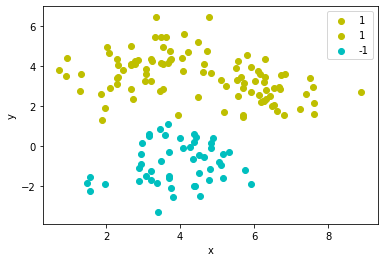

In [5]:
plt.scatter(label0[:,0],label0[:,1],c="y",label=1)
plt.scatter(label2[:,0],label2[:,1],c="y",label=1)
plt.scatter(label1[:,0],label1[:,1],c="c",label=-1)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

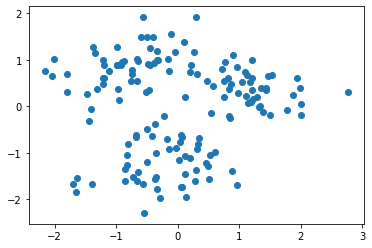

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

plt.scatter(X[:,0],X[:,1])
plt.show()

## SVMのフルスクラッチ実装(Hardmergin)

最適化手法のおさらい  
$$
\begin{align}
\mathrm{w} &= \sum_{i = 1}^{N}\lambda_i y_i x_i  \\
b &= y_i-\sum_{i=1}^{N}\sum_{j=1}^{N}(\lambda_i y_i x_i^T x_j) \\
\lambda_i^{(n+1)} &= \lambda_i^{(n)} + \alpha(1-\sum_{j=1}^{N} \lambda_j y_i y_j K(x_i,x_j))
\end{align}
$$
Kはカーネル法を使う場合に使用する


In [11]:
class SvmFullScratch:
    def __init__(self,iter_num=20,lr=1e-3,kernel='linear'):
        self.iter_num = iter_num
        self._lr = lr
        self._kernel = kernel
        self._sv = []
        self._y = []
        
        
    def _lagrange(self, X, y):
        for i in range(len(X)):
            lam_sum = 0
            for j in range(len(X)):
                lam_sum += self._lambda[j] * y[i] * y[j] * self.kernel(X[i],X[j])
            self._lambda[i] += self._lr*(1-lam_sum)
            
            if self._lambda[i] < 0:
                self._lambda[i] = 0
        
    def train(self, X, y):
        self._lambda = np.random.rand(len(X),1)
        for i in range(self.iter_num):
            self._lagrange(X,y)
            
        index_sv = np.where(self._lambda >= 1e-6)[0]
        print(index_sv)
        self._lambda = self._lambda[index_sv]
        self._sv = X[index_sv]
        self._y = y[index_sv]
    
    def kernel(self, xi, xj):
        if self._kernel == "linear":
            K = np.dot(xi.T,xj)
            return K
        elif self._kernel == "poly":
            gamma = 1.0
            d = 6
            K = (np.dot(xi.T,xj) + gamma)**d
            return K
        else:
            print("cannot found", self._kernel)
    
    def predict(self,X):
        y_hat = 0
        print(X.shape)
        print(self._sv)
        for i in range(len(self._sv)):
            y_hat += self._lambda[i] * self._y[i] * self.kernel(X.T, self._sv[i].T)
        return y_hat
            

In [8]:
from matplotlib.colors import ListedColormap

# 可視化関数
def plot_decision_regions(X, model):
    plt.scatter(X[:,0], X[:,1], s=80, c=y, marker='o')
    #print(model.sv_lt)
    for sv in model._sv:
        plt.scatter(sv[0], sv[1], s=80, c='c', marker='o')
    
    #サポートベクターも同様にプロット
    step = 0.1
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-1.0, np.max(X[:,0])+1.0, step), np.arange(np.min(X[:,1])-1.0, np.max(X[:,1])+1.0, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)
    plt.contour(mesh_f0, mesh_f1, pred, 1)
    plt.show()

[ 16  19  29  30  34  52  60  62  74  79  82  83  90  91  94 103 109 112
 113 118 122 124 130 132 138 140 141 143 148]
(4410, 2)
[[ 0.84072694 -0.20051635]
 [ 0.32175787  0.70276234]
 [-0.13335073  0.75574086]
 [ 0.04539848 -0.77437223]
 [ 0.07266456 -0.66612371]
 [ 0.48372486  0.55453775]
 [-0.21587995 -0.20374178]
 [ 0.0459844  -0.61697853]
 [ 0.11270448  0.19194002]
 [-0.45993054  0.35375085]
 [-1.44761173 -0.31204168]
 [-0.37162301 -0.38381325]
 [ 0.6137381  -0.99205568]
 [-0.50906593  0.31947672]
 [-0.68076758 -0.6560314 ]
 [ 0.31859235 -0.9225991 ]
 [ 0.5660308   0.43611216]
 [ 0.85005766 -0.25248264]
 [ 0.19986933  0.73594528]
 [-0.73866049  0.69139691]
 [-0.48623738  0.91863536]
 [-0.68201174 -0.61313925]
 [-0.02387543 -0.90147821]
 [ 0.53410981 -0.14118205]
 [-0.64308156  0.9759605 ]
 [ 0.75436944  0.55234832]
 [ 1.17609003  0.09785065]
 [-0.94914494  0.14760251]
 [-0.13897795 -0.90884624]]


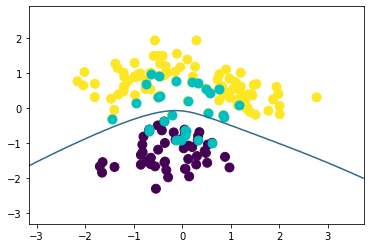

In [12]:
svm = SvmFullScratch(20, 1e-4,kernel="poly")
svm.train(X, y)
plot_decision_regions(X,svm)